# E-commerce Fraud Detection Analysis

## 1. Exploratory Data Analysis

### Read CSV and understand data format

In [20]:
import glob
import pandas as pd
import seaborn as sns

In [6]:
# datafiles
glob.glob('./data/*')

['./data/test_transaction.csv',
 './data/train_identity.csv',
 './data/test_identity.csv',
 './data/sample_submission.csv',
 './data/train_transaction.csv']

In [8]:
df_id = pd.read_csv('./data/train_identity.csv')
df_transaction = pd.read_csv('./data/train_transaction.csv')

### Identity Table

There are 41 columns in this table, including different 
identity information such as network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. These data is collected by Vesta’s fraud protection system and digital security partners. Field names are masked for privacy reasons.

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [14]:
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [49]:
len(df_id.columns)

41

### Transaction Table

There are 394 columns in this table. The organization provided additinoal explanation regarding these variables.
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

In [11]:
df_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
len(df_transaction.columns)

394

### Data Exploration

Out of 590,540 data records, only ~3.5% are fraud transactions. It is very likely to encounter inbalanced classes in fraud detection problems. We will experiment with different ways to handle this, including various data sampling methods and using non-accuracy measures to evaluate model.

In [28]:
'Total number of Transactions', len(df_transaction.isFraud)

('Total number of Transactions', 590540)

('Ratio of fradulent transactions', 0.03499)

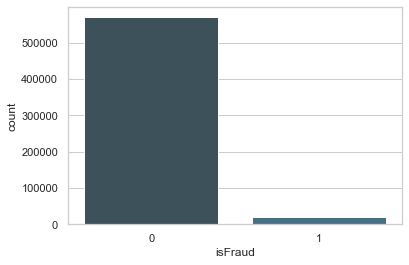

In [46]:
sns.set_palette('GnBu_d')
sns.countplot(x = 'isFraud', data = df_transaction)
'Ratio of fradulent transactions'\
, round(sum(df_transaction.isFraud)/ len(df_transaction.isFraud),5)

###  Handle missing data